In this notebook, I'll try to model out some understanding of a network structure. The supporter modeling notebook suggests that a market might have a sigmoidal response to increased patron funds. In this notebook, we'll try to understand how a ecosystem of data markets might benefit from the presence of a funding DAO at the network level. Let's start by introducing some simulation parameters.

In [1]:
# Let's assume there are some number of markets created
NUM_MARKETS = 10
# Let's say that each market has a cap
# Note we're not using WHOLE. This makes numerical stability much nicer....
MARKET_CAP = 100000
# The number of patrons supporting the ecosystem
NUM_PATRONS = 1000
# The size of an average support
SUPPORT_SIZE = 500
# This is the point at which a market growth starts to saturate and further support becomes less helpful
MARKET_SATURATION = 10000 # in ETH

## The patronage parameters
# Let's assume that each patron has a small chance of supporting a given market
PROB_ONE_MARKET_SUPPORT = .02
# Let's model in some market risk by assuming that each market has a chance of failing
PROB_ONE_MARKET_FAIL = .0

## The index fund parameters
# Probability a patron supports the index fund
PROB_INDEX_FUND = .10

We're modeling an ecosystem with `NUM_MARKETS` different data markets, each of which is assumed to have a possible size of `MARKET_CAP`. It's important to note this is a critical assumption of the current simulation. It's pretty nontrivial to bootstrap a lively market right now, so this simulation notebook is looking pretty far ahead. With that note our of the way, let's see what we can learn. We're going to assume that a market's response curve to patron funds is given by

$y = \text{MARKET_CAP} \cdot \text{sigmoid}(x / \text{MARKET_SATURATION}) - (\text{MARKET_CAP}/2)$

Let's use this simple equation to create a mathematical model of the size of a market ecosystem.

In [8]:
import numpy as np
from scipy.special import expit

# Define the response
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.special.expit.html
# expit is numerically stable which makes the simulations much nicer.
def get_market_size(funds):
    return MARKET_CAP * expit(funds / MARKET_SATURATION) - (MARKET_CAP / 2)

Let's build some basic understanding of the dynamics of this function by plotting it.

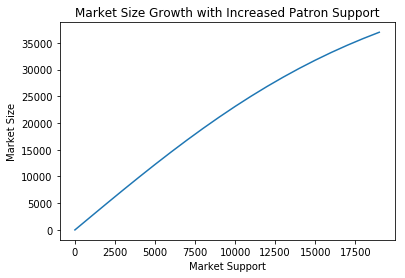

In [9]:
import matplotlib.pyplot as plt

funding_levels = [1000 * i for i in range(2 * MARKET_SATURATION // 1000)]
market_sizes = [get_market_size(funding_level) for funding_level in funding_levels]
plt.title("Market Size Growth with Increased Patron Support")
plt.xlabel("Market Support")
plt.ylabel("Market Size")
plt.plot(funding_levels, market_sizes)

In [4]:
NUM_REPS = 20
def run_basic_simulation():
    total_market_cap = 0
    total_market_size = 0
    market_supports = []
    market_sizes = []

    for i in range(NUM_MARKETS):
        market_support = 0
        for j in range(NUM_PATRONS):
            u = np.random.uniform()
            if u < PROB_ONE_MARKET_SUPPORT:
                market_support += SUPPORT_SIZE
        market_supports.append(market_support)
        # Now check if the market fails
        f = np.random.uniform()
        if f < PROB_ONE_MARKET_FAIL:
            market_size = 0
        else:
            market_size = get_market_size(market_support)
        market_sizes.append(market_size)
        total_market_size += market_size
    avg_market_support = np.mean(np.array(market_supports))
    avg_market_size = np.mean(np.array(market_sizes))
    return avg_market_support, avg_market_size, total_market_size

network_sizes = []
avg_market_supports = []
avg_market_sizes = []
for rep in range(NUM_REPS):
    avg_market_support, avg_market_size, total_market_size = run_basic_simulation()
    network_sizes.append(total_market_size)
    avg_market_supports.append(avg_market_support)
    avg_market_sizes.append(avg_market_size)

avg_market_size = np.mean(np.array(network_sizes))
std_deviation = np.std(np.array(network_sizes))
print("Average market support: %f" % np.mean(np.array(avg_market_supports)))
print("Average market size: %f" % np.mean(np.array(avg_market_sizes)))
print("Average Network Size across reps: %f" % avg_market_size)
print("Standard deviation: %f" % std_deviation)
basic_avg_network_size = avg_market_size

Average market support: 9997.500000
Average market size: 22847.356127
Average Network Size across reps: 228473.561270
Standard deviation: 12442.880628


Now let's assume a simple network structure. There exists a DAO which acts as an "index fund" of datasets. The simulation structure is the same as above, but we'll assume that there's a probability the patron chooses to support the index fund.

In [5]:

# Let's find the size of the index fund
total_index_fund_size = 0
for j in range(NUM_PATRONS):
    u = np.random.uniform()
    if u < PROB_INDEX_FUND:
        total_index_fund_size += SUPPORT_SIZE
print("Total Index Fund Size: %d" % total_index_fund_size)

Total Index Fund Size: 46000


Let's say that this index fund's sole purpose is to support the community, so it takes its total funds and splits it across all markets. Let's add this on top of the existing support code as above to see what the benefit is.

In [6]:
NUM_REPS = 20

def run_index_fund_simulation():
    total_market_cap = 0
    total_market_size = 0
    index_fund_support = total_index_fund_size / NUM_MARKETS
    market_supports = []
    market_sizes = []

    for i in range(NUM_MARKETS):
        market_support = 0
        for j in range(NUM_PATRONS):
            u = np.random.uniform()
            if u < PROB_ONE_MARKET_SUPPORT:
                market_support += SUPPORT_SIZE
        market_support += index_fund_support
        market_supports.append(market_support)
        # Now check if the market fails
        f = np.random.uniform()
        if f < PROB_ONE_MARKET_FAIL:
            market_size = 0
        else:
            market_size = get_market_size(market_support)
        market_sizes.append(market_size)
        total_market_size += market_size
    avg_market_support = np.mean(np.array(market_supports))
    avg_market_size = np.mean(np.array(market_sizes))
    return avg_market_support, avg_market_size, total_market_size

network_sizes = []
avg_market_supports = []
avg_market_sizes = []
for rep in range(NUM_REPS):
    avg_market_support, avg_market_size, total_market_size = run_index_fund_simulation()
    avg_market_supports.append(avg_market_support)
    avg_market_sizes.append(avg_market_size)
    network_sizes.append(total_market_size)
avg_market_size = np.mean(np.array(network_sizes))
std_deviation = np.std(np.array(network_sizes))
print("Average market support: %f" % np.mean(np.array(avg_market_supports)))
print("Average market size: %f" % np.mean(np.array(avg_market_sizes)))
print("Average Network Size across reps: %f" % avg_market_size)
print("Standard deviation: %f" % std_deviation)
index_avg_network_size = avg_market_size

Average market support: 14762.500000
Average market size: 31184.922756
Average Network Size across reps: 311849.227564
Standard deviation: 11845.915982


This crude analysis suggests that the presence of a network-wide index fund allows for a some boost in the total network outcome.

In [13]:
print("Basic Network Size: %.2f" % basic_avg_network_size)
print("Total size index fund: %.2f" % total_index_fund_size)
print("Index Network Size: %.2f" % index_avg_network_size)
print("Index Effect: %.2f" % (index_avg_network_size - basic_avg_network_size))

index_return = ((index_avg_network_size - basic_avg_network_size) / total_index_fund_size - 1) * 100
print("Index Return Percent: %f%%" % index_return)

Basic Network Size: 228473.56
Total size index fund: 46000.00
Index Network Size: 311849.23
Index Effect: 83375.67
Index Return Percent: 81.251448%


Note that this model only provides returns because the markets are in the middle of their growth phase so the presence of the index fund makes a noticeable difference in their outcomes. In general, the index fund would need some intelligence to understand 